# Mixture of Gaussians

The Gaussian Mixtures model is useful in unsupervised learning problems, where we have the data, $x \in D$, but no labels. In this case the focus is on density estimation. The model assumes the data were generated from some "latent" or unobserved variable, $z$. Specifically, the data were randomly generated from one of k latent variables ($z_i$), then $x_i$ was sampled from one of k gaussians depending on $z_i$. The liklihood of the data is:

$l(\phi, \mu, \Sigma) = \sum\limits_{i=1}^mlog p(x_i;\phi, \mu, \Sigma) = \sum\limits_{i=1}^m log\sum\limits_{z_i=1}^k p(x_i|z_i;\mu, \Sigma)P(z_i; \phi)$

If we take derivitives w.r.t. the parameters and set them to zero, it is not possible to find the Maximum Likihood Estimate (MLE) in closed form. We therefore use the machinery of Expectation Maximisation (EM).

The algorithm is iterative and made up of two steps:

- Step 1: Expectation (based on the parameters, make soft estimate of which $z_i$, $x_i$ belongs to)
    - Choose Q to get tight lower bound on $l(\theta)$
    - $Q_i(z_i)=P(z_i|x_i; \theta)$


- Step 2: Maximisation (update parameters)
    - Choose parameter, $\theta$, to maximise lower bound
    - $\theta =$argmax$_\theta \sum\limits_i\sum\limits_{z_i}Q_i(z_i)log \frac{P(x_i, z_i;\theta)}{Q_i(z_i)}$

In step 1, $Q_i$ is a probability of the latent variables $z$, given the data. We can use Bayes rule to calculate this analytically as follows:

$w_j^{(i)} = P(z^{(i)} = j| x^{(i)}, \phi, \mu, \Sigma) = \frac{P(x^{(i)}|z^{(i)}=j)P(z^{(i)}=j)}{\sum\limits_{i=1}^kP(x^{(i)}|z^{(i)}=j)P(z^{(i)}=j)}$

$x|z$ is sampled from a Gaussian distribution parameterised by $\mu$ and $\Sigma$. $z$ is sampled from a Multinomial distribution parameterised by $\phi$. Our posterior is then also Gaussian.

In step 2, we perform MLE to obtain the parameters, where parameters $\theta$ are formed of $\phi$, $\mu$, $\sigma$:

- $\phi_j = \frac{1}{M}\sum\limits_{i=1}^mw_{ji}$
- $\mu_j = \frac{1}{M}\sum\limits_{i=1}^mw_{ji}x/(\sum\limits_{i=1}^m w_{ji})$
- $\Sigma_j = \frac{1}{M}\sum\limits_{i=1}^mw_{ji}(x_i- \mu_j)(x_i- \mu_j)^T/(\sum\limits_{i=1}^m w_{ji})$

# Univeriate case
## Generate dataset

In [28]:
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def gaussian(x, mu=0, sigma=1):
    return 1/(2*np.pi*sigma**2)**2 * np.exp(-0.5*((x-mu)/sigma)**2)

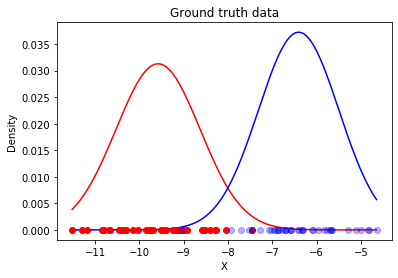

In [30]:
np.random.seed(11)
# np.random.seed(190)
# np.random.seed(1298)
X, y = make_blobs(n_samples=[40]*2, n_features=1)
xx = np.linspace(X.min(), X.max(), 200)
x1 = X[y.astype(bool)]
x2 = X[~y.astype(bool)]
yy1 = gaussian(xx, mu=x1.mean(), sigma=x1.std())
yy2 = gaussian(xx, mu=x2.mean(), sigma=x2.std())

f, ax = plt.subplots()
ax.plot(xx, yy1, 'r')
ax.plot(xx, yy2, 'b')
ax.plot(x1, np.zeros(len(x1)), 'ro')
ax.plot(x2, np.zeros(len(x2)), 'bo', alpha=0.3)
ax.set(title='Ground truth data', xlabel='X', ylabel='Density')
plt.show()

# from scratch

In [31]:
class GMMnp:
    def __init__ (self, n_comps = 2, n_iters = 1000, tol = 1e-3):
        self.n_comps = n_comps
        self.n_iters = n_iters
        self.tol = tol
    
    def train(self, X):
        self.phis = np.random.uniform(0,1,self.n_comps) 
        self.phis /= self.phis.sum() # must sum to 1 
        self.mus = np.random.uniform(-10,10,self.n_comps)
        self.sigmas = np.random.uniform(0,2,self.n_comps)
        for i in range(self.n_iters):
            # E step, w = Q(z|x), i.e. soft estimate of which data point belongs to which gaussian
            p_x = np.array([gaussian(X, mu=self.mus[j], 
                                     sigma=self.sigmas[j]) * self.phis[j] 
                            for j in range(self.n_comps)]).sum(0)
            
            w = np.zeros((X.shape[0], self.n_comps))
            for j in range(self.n_comps):
                w[:,[j]] = gaussian(X, mu=self.mus[j], sigma=self.sigmas[j]) * self.phis[j]/p_x

            # M step, compute MLE to update parameters
            self.phis = w.mean(0)
            self.mus = (w * X).mean(0) / self.phis
            self.sigmas = ((w * (X - self.mus)**2).mean(0) / self.phis)**0.5

            if (i > 0) and np.abs(mu_prev - self.mus).sum() + np.abs(sig_prev - self.sigmas).sum() < self.tol:
                print(f'Converged after {i+1} iterations.')
                break
            else:
                mu_prev = self.mus
                sig_prev = self.sigmas
        
    def predict(self, X):
        p_x = np.array([gaussian(X, mu=self.mus[j], 
                         sigma=self.sigmas[j]) * self.phis[j] 
                        for j in range(self.n_comps)]).sum(0)

        w = np.zeros((X.shape[0], self.n_comps))
        for j in range(self.n_comps):
            w[:,[j]] = gaussian(X, mu=self.mus[j], sigma=self.sigmas[j]) * self.phis[j]/p_x
            
        return w.argmax(1)
    
    def ll_score(self, X):
        w = np.zeros((X.shape[0], self.n_comps))
        for j in range(self.n_comps):
            w[:,[j]] = gaussian(X, mu=self.mus[j], sigma=self.sigmas[j]) * self.phis[j]
        return np.log(w.sum(1))

In [32]:
np.random.seed(2)
gmm_np = GMMnp()
gmm_np.train(X)
gmm_np.phis, gmm_np.mus, gmm_np.sigmas

Converged after 10 iterations.


(array([0.49231027, 0.50768973]),
 array([-9.61452932, -6.41705587]),
 array([0.92573916, 0.89371836]))

## Sci-kit learn

In [33]:
gmm = GaussianMixture(n_components=2,random_state=13, covariance_type='spherical').fit(X)
gmm.weights_, gmm.means_, gmm.covariances_**0.5

(array([0.50399834, 0.49600166]), array([[-9.57808237],
        [-6.37874335]]), array([0.94949775, 0.86324185]))

## Comparisons

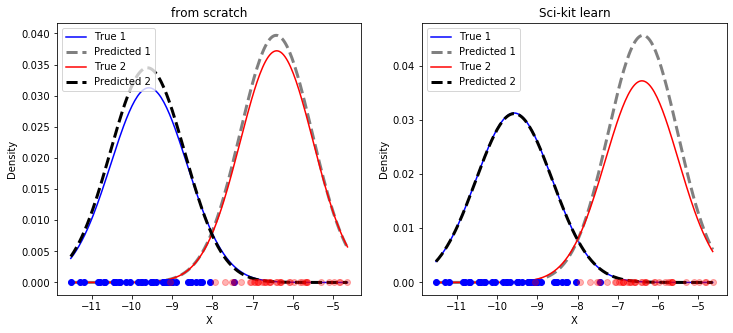

In [34]:
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(xx, yy1, 'b', label='True 1')
ax[0].plot(xx, gaussian(xx, gmm_np.mus[1], gmm_np.sigmas[1]), '--', color='gray', lw=3, label='Predicted 1')
ax[0].plot(xx, yy2, 'r', label='True 2')
ax[0].plot(xx, gaussian(xx, gmm_np.mus[0], gmm_np.sigmas[0]), 'k--', lw=3, label='Predicted 2')
ax[0].plot(x1, np.zeros(len(x1)), 'bo')
ax[0].plot(x2, np.zeros(len(x2)), 'ro', alpha=0.3)
ax[0].set(title='from scratch', xlabel='X', ylabel='Density')
ax[0].legend(loc='upper left')

ax[1].plot(xx, yy1, 'b', label='True 1')
ax[1].plot(xx, gaussian(xx, gmm.means_[1], gmm.covariances_[1]**0.5), '--', color='gray', lw=3, label='Predicted 1')
ax[1].plot(xx, yy2, 'r', label='True 2')
ax[1].plot(xx, gaussian(xx, gmm.means_[0], gmm.covariances_[0]**0.5), 'k--', lw=3, label='Predicted 2')
# ax[1].plot(xx, gmm.score_samples(xx.reshape(-1,1)), 'b', label='True 1')
ax[1].plot(x1, np.zeros(len(x1)), 'bo')
ax[1].plot(x2, np.zeros(len(x2)), 'ro', alpha=0.3)
ax[1].set(title='Sci-kit learn', xlabel='X', ylabel='Density')
ax[1].legend(loc='upper left')
plt.show()

## Scoring samples
- sci-kit learn computes liklihhod scores differently
- the precision matrix is used instead of the covariance as it is more efficient at test time
- return to this later

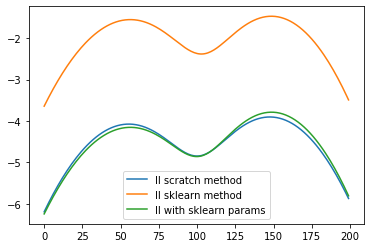

In [35]:
# scratch method
nll =  gmm_np.ll_score(xx.reshape(-1,1))

# sklearn method
nll_sk = gmm.score_samples(xx.reshape(-1,1))

# using sklearn params
mus = gmm.means_
sigmas = gmm.covariances_**0.5
phis = gmm.weights_
n_comps = 2
w = np.zeros((xx.shape[0], n_comps))
for j in range(n_comps):
    w[:,[j]] = gaussian(xx.reshape(-1,1), mu=mus[j], sigma=sigmas[j]) * phis[j]
w = np.log(w[:,0]+w[:,1])

plt.plot(nll, label='ll scratch method')
plt.plot(nll_sk, label='ll sklearn method')
plt.plot(w, label='ll with sklearn params')
plt.legend()